# Case studies
Run sample test cases of Jacobian determinant computation to analyze what cases may cause negative determinants.

In [3]:
%load_ext autoreload
%autoreload 2

# Standard imports
import sys
sys.path.append("../../")
import time
import gc

# 3rd party imports
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import nibabel as nib
import numpy as np 
import scipy 
import SimpleITK as sitk
from tqdm import tqdm 

# Our libraries
import modules.laplacian as laplacian 
import modules.correspondences as correspondences
import modules.jacobian as jacobian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Jacobian functions

In [4]:
def test_det(up_coord, bottom_coord, left_coord, right_coord, debug=False):
    """
    Compute the Jacobian determinant at a specific point in the deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    - coord: The coordinates of the point (z, y, x).
    
    Returns:
    - det: The Jacobian determinant at the specified point.
    """
    #print(coord)
    
    # Compute the partial derivatives
    dFx_dx = (right_coord[0] - left_coord[0]) / 2
    dFx_dy = (up_coord[0] - bottom_coord[0]) / 2
    #print(dFx_dx, dFx_dy, dFx_dz)
    #print(deformation[2, z, y, x + 1], "-", deformation[2, z, y, x - 1])

    dFy_dx = (right_coord[1] - left_coord[1]) / 2
    dFy_dy = (up_coord[1] - bottom_coord[1]) / 2

    # Form the Jacobian matrix
    # Note that the determinant of a zero vector field is also zero, whereas the Jacobian determinant of the corresponding identity warp transformation is 1.0. 
    # In order to compute the effective deformation Jacobian determinant 1.0 must be added to the diagonal elements of Jacobian prior to taking the derivative. 
    # i.e. det([ (1.0+dx/dx) dx/dy dx/dz ; dy/dx (1.0+dy/dy) dy/dz; dz/dx dz/dy (1.0+dz/dz) ])
    jacobian_matrix = np.array([
        [dFx_dx + 1, dFx_dy],
        [dFy_dx, dFy_dy + 1]
    ])
    
    if debug:
        print("(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)")
        print("\t" + str(dFx_dx + 1) + " * " + str(dFy_dy + 1) + " - " + str(dFx_dy) + " * " + str(dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1)) + " - " + str(dFx_dy * dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1) - dFx_dy * dFy_dx))
        print("Jacobian")
        print(jacobian_matrix)

    # Compute the determinant of the Jacobian matrix
    det = np.linalg.det(jacobian_matrix)

    return det

# Test it here
up_vec = np.array([1, 2])
bottom_vec = np.array([2, 6])
left_vec = np.array([-6, 1])
right_vec = np.array([4, 3])
print(test_det(up_vec, bottom_vec, left_vec, right_vec, debug=True))

(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)
	6.0 * -1.0 - -0.5 * 1.0
	-6.0 - -0.5
	-5.5
Jacobian
[[ 6.  -0.5]
 [ 1.  -1. ]]
-5.499999999999999


Good cases

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  0.  0.  0. -2. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0.  0. -2. -1.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.  

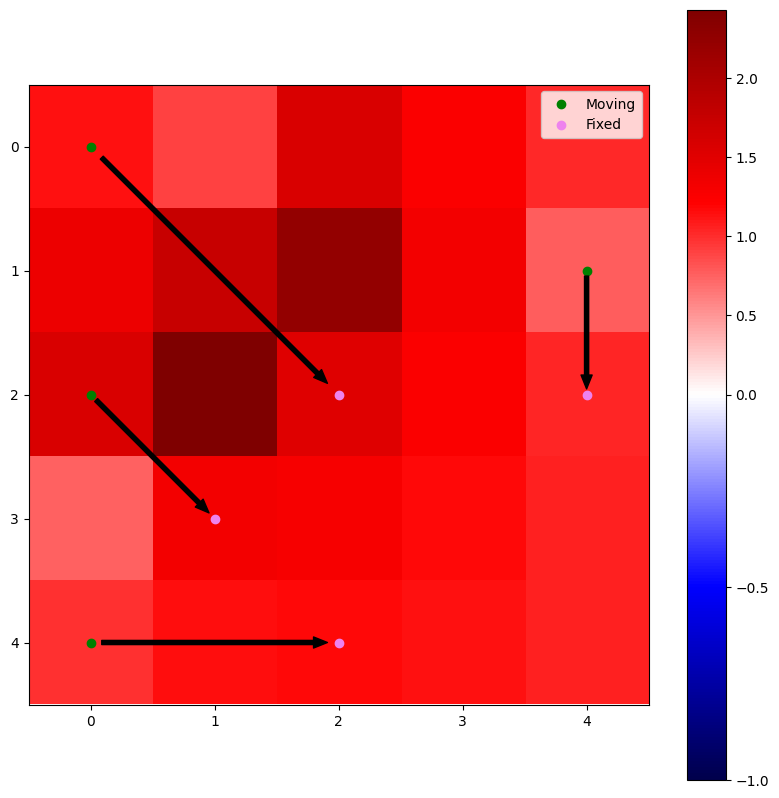

In [5]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 0],
    [0, 2, 0],
    [0, 4, 0],
    [0, 1, 4],
])
fsample = np.array([
    [0, 2, 2],
    [0, 3, 1],
    [0, 4, 2],
    [0, 2, 4],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Intersection

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (25, 25)
[[ 2. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  

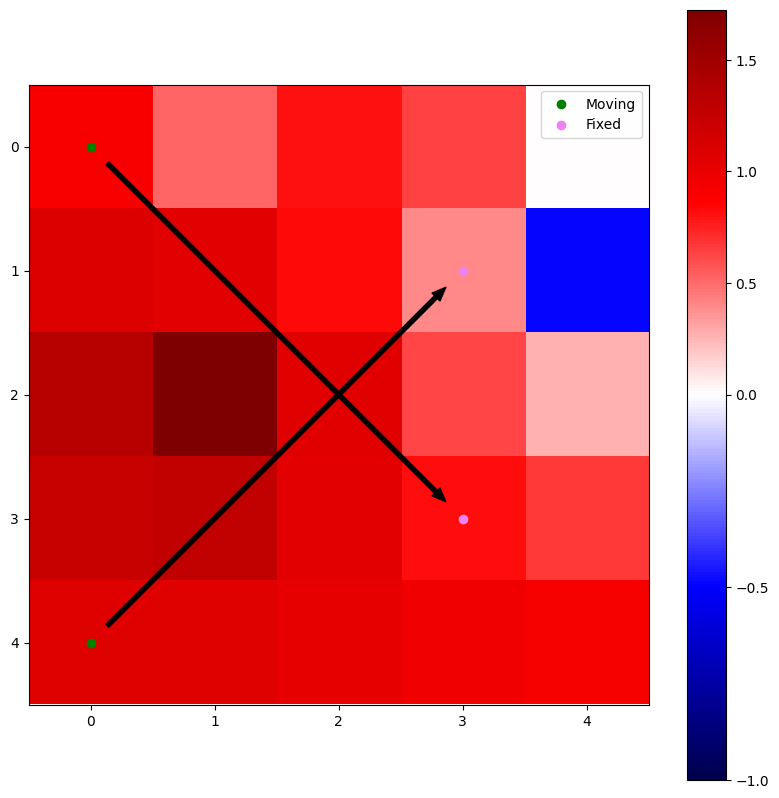

[[[ 0.90069822  0.51420839  0.79809204  0.6392055   0.00396064]
  [ 1.08946808  1.04096428  0.82673487  0.40128006 -0.48874646]
  [ 1.34207464  1.72577843  1.05811013  0.63355875  0.26488775]
  [ 1.22708638  1.26977564  1.04267191  0.82225776  0.66317394]
  [ 1.07686608  1.07843416  1.0213279   0.95474085  0.90601968]]]


In [6]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

print(jacobian_det)

Orientation

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  3. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.81114025  0.68092691  0.53023391  0.33909901  0.        ]
   [ 0.99990617  0.71940635  0.56482518  0.43228325  0.30938259]
   [ 0.77152757  0.67458764  0.57953895  0.49675209  0.43915477]
   [ 0.68743006  0.64275208  0.58462673  0.5319277   0.49881142]
   [ 0

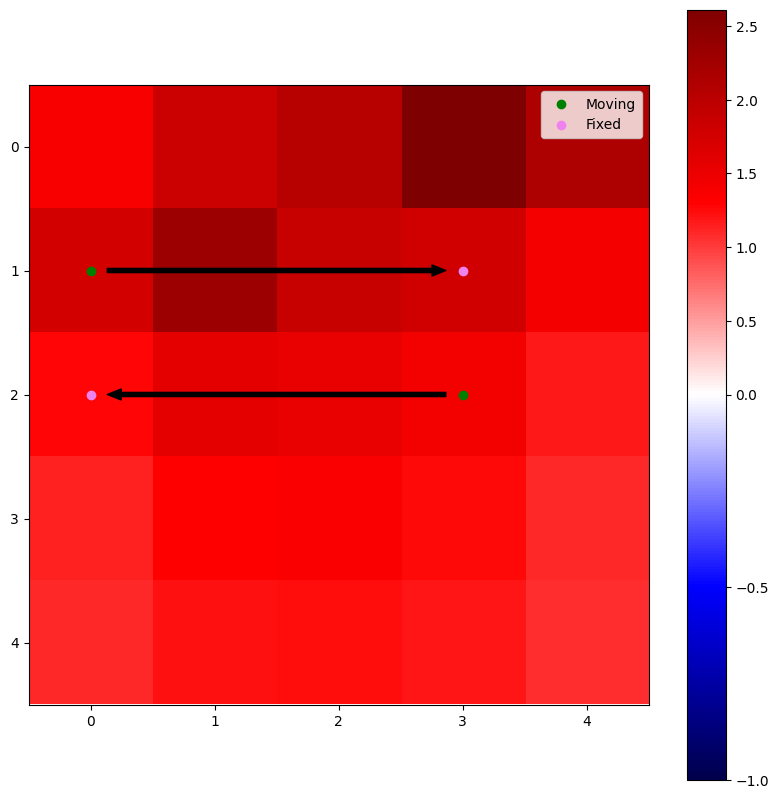

In [7]:
# Create some example correspondence points
msample = np.array([
    [1, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  3.  0.  0.  0.  0.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 4.19960102e-01  3.92225413e-01  3.01660875e-01  0.00000000e+00  4.99562393e-01]
   [ 4.43451425e-01  4.38899955e-01  4.37884260e-01  4.99464716e-01  9.99948462e-01]
   [ 4.70219392e-01  4.77471656e-01  4.99586595e-01  5.60586934e-01  6.96602802e-01]
   [ 4.8939

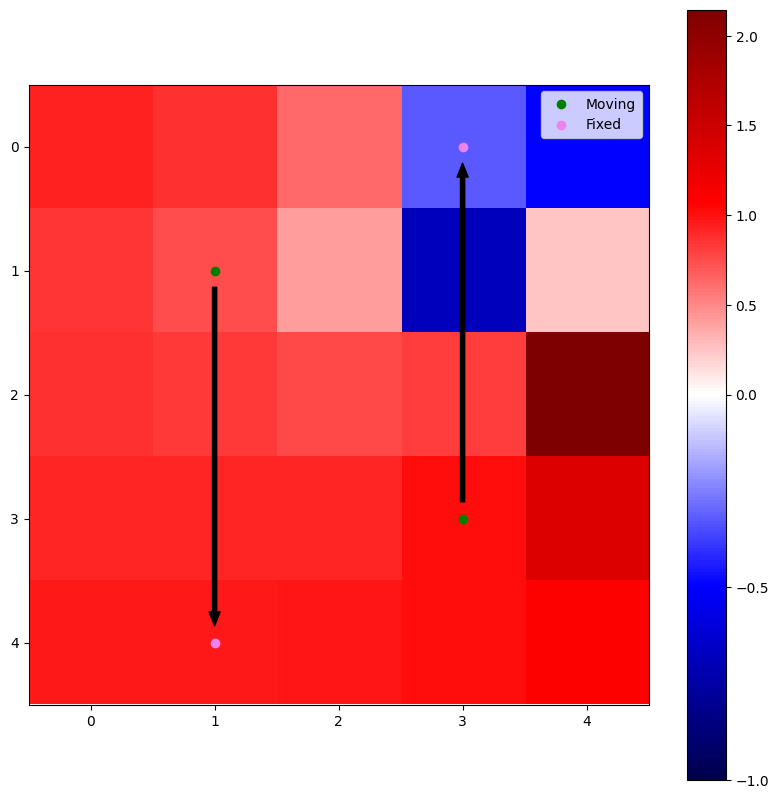

In [8]:
# Create some example correspondence points
msample = np.array([
    [1, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Magnitude

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0

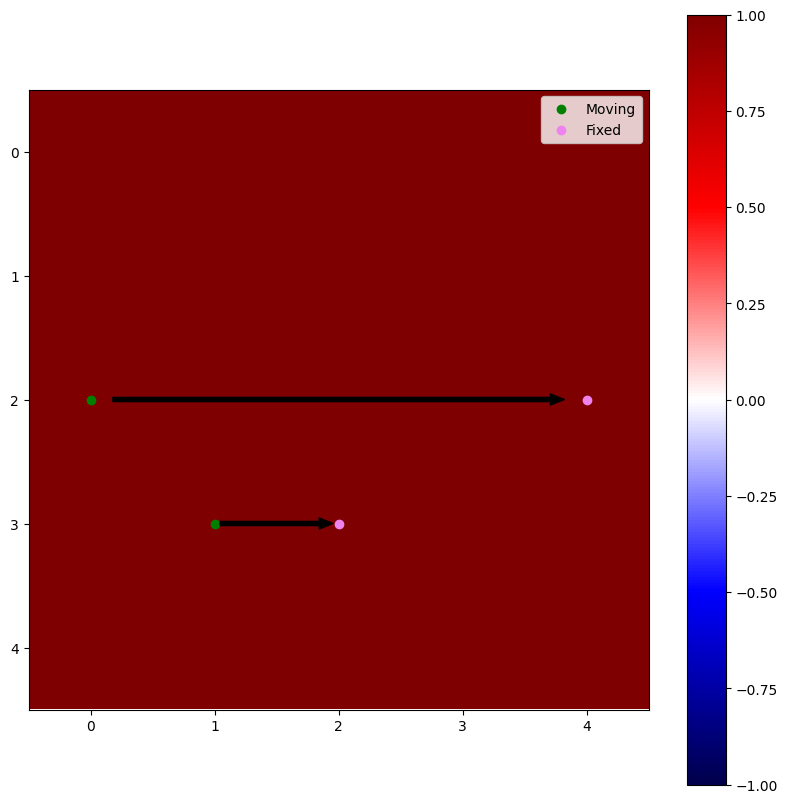

In [9]:
# Create some example correspondence points
msample = np.array([
    [1, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0

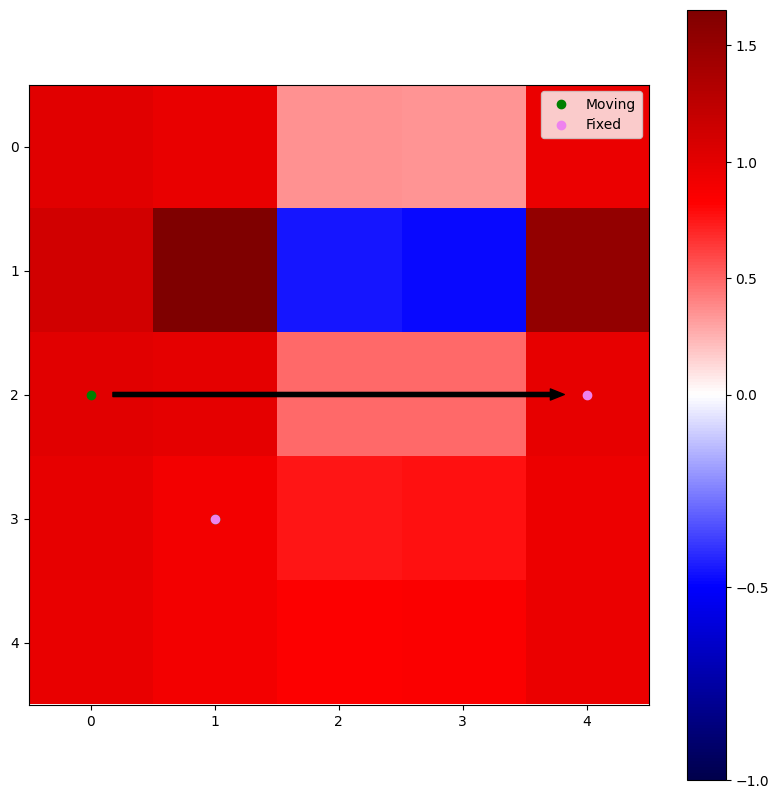

In [10]:
# Create some example correspondence points
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 1],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Are these conditions independent?

Orientation

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0

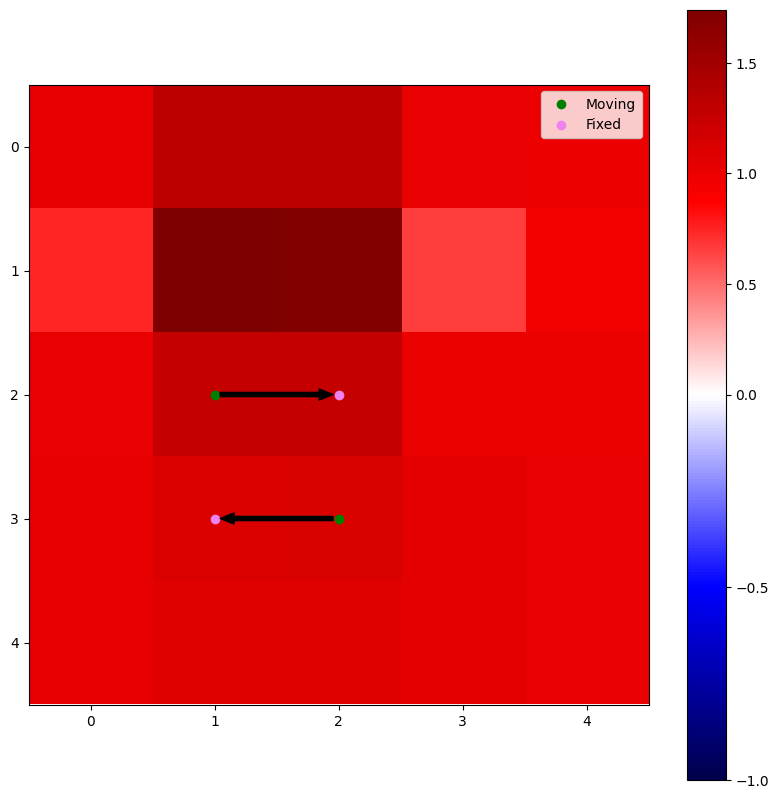

In [11]:
# Create some example correspondence points
msample = np.array([
    [0, 2, 1],
    [0, 3, 2],
])
fsample = np.array([
    [0, 2, 2],
    [0, 3, 1],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.        ]]

  [[0.        

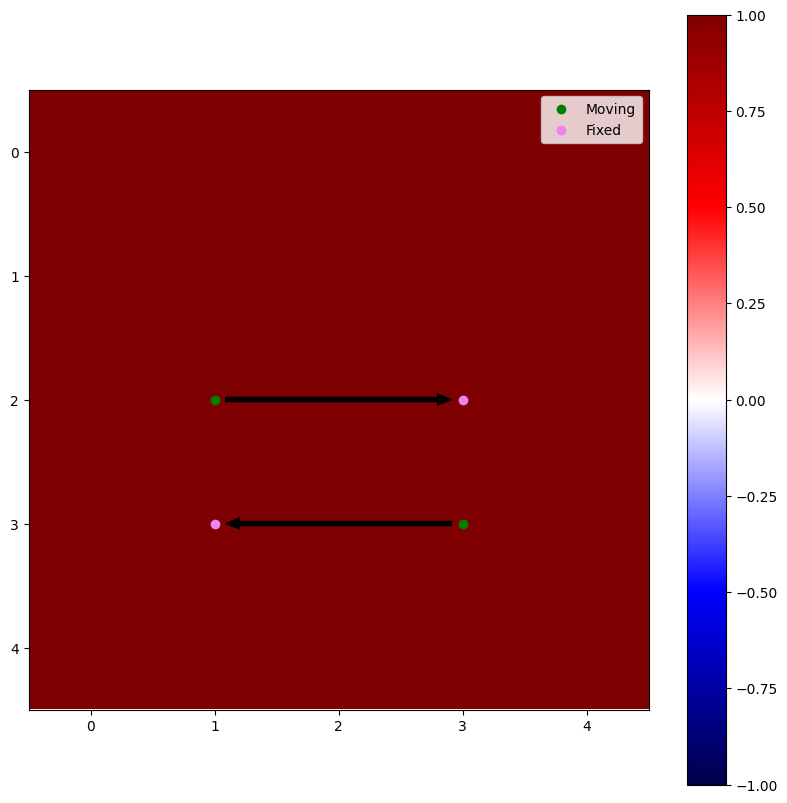

In [12]:
# Create some example correspondence points
msample = np.array([
    [0, 2, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 2, 3],
    [0, 3, 1],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Intersection

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0. -2.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.  

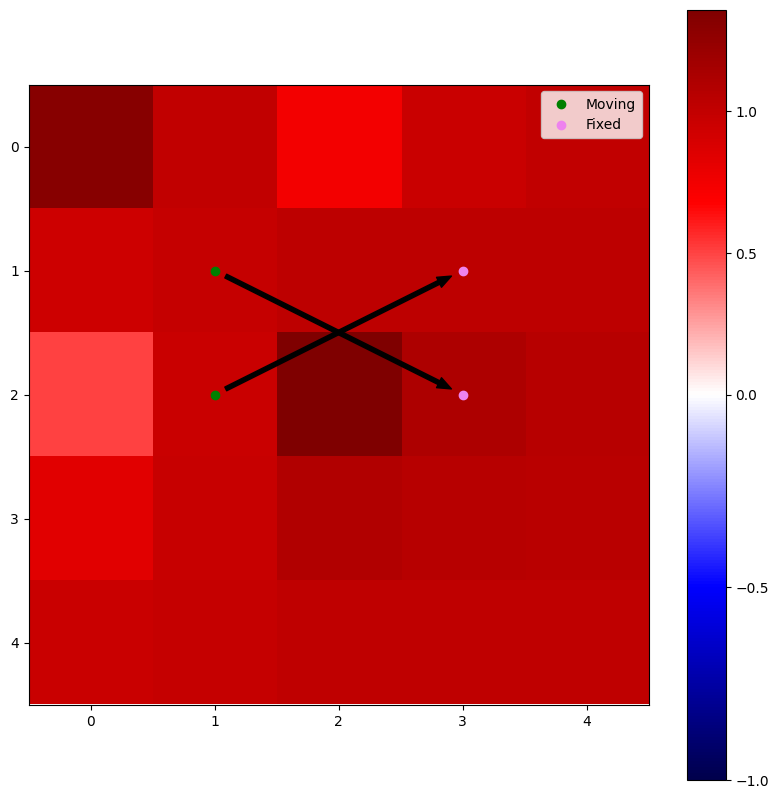

In [13]:
# Create some example correspondence points
msample = np.array([
    [0, 1, 1],
    [0, 2, 1],
])
fsample = np.array([
    [0, 2, 3],
    [0, 1, 3],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0. -3.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.  

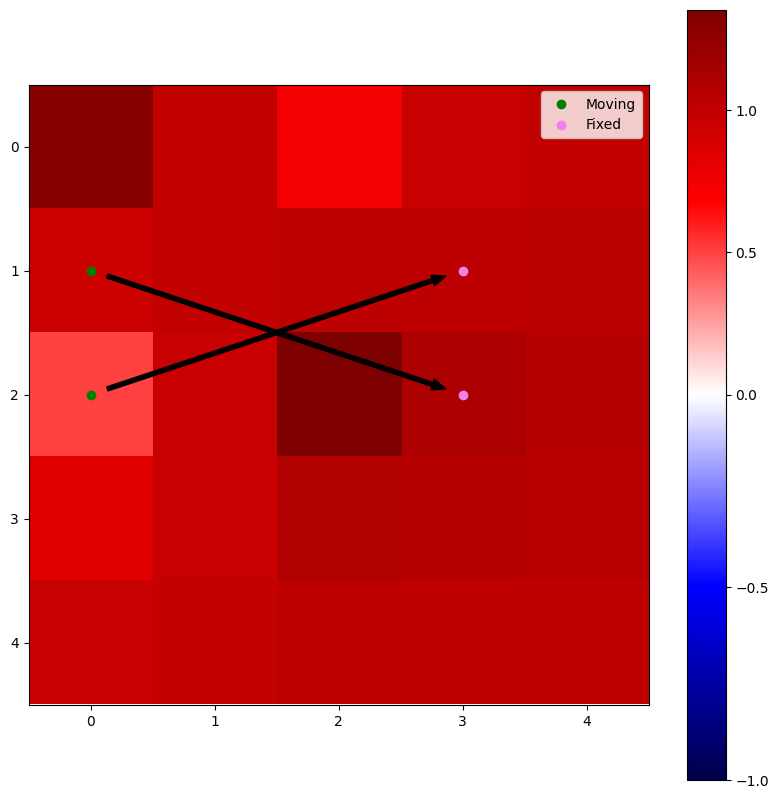

In [14]:
# Create some example correspondence points
msample = np.array([
    [0, 1, 0],
    [0, 2, 0],
])
fsample = np.array([
    [0, 2, 3],
    [0, 1, 3],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  0.  0.  1.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0. -2.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.  

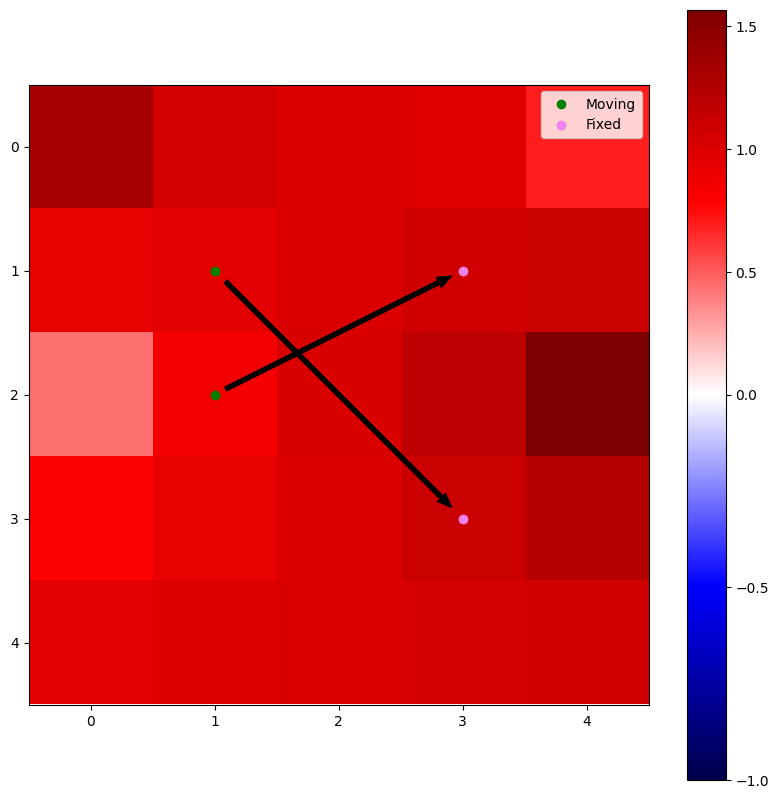

In [15]:
# Create some example correspondence points
msample = np.array([
    [0, 1, 1],
    [0, 2, 1],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])


# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

In 3D

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0

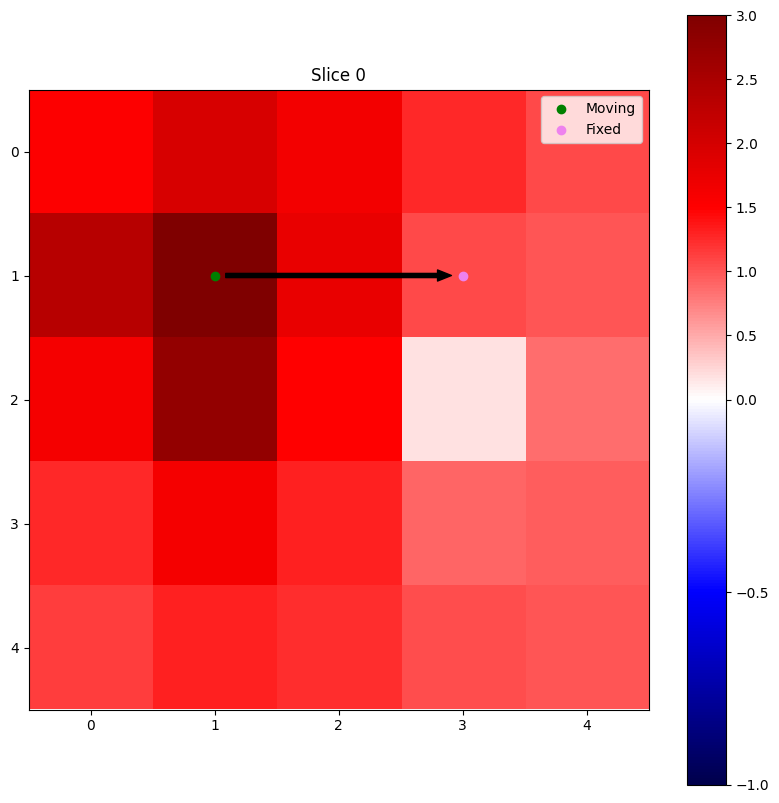

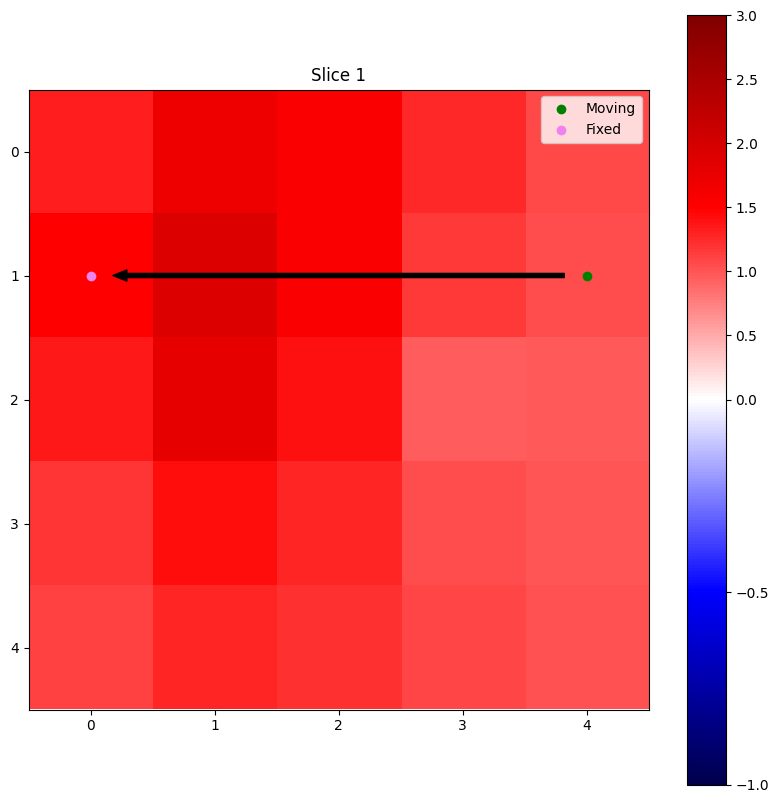

In [16]:
# Create some example correspondence points
msample0 = np.array([
    [0, 1, 1],
#    [0, 3, 1],
])
fsample0 = np.array([
    [0, 1, 3],
#    [0, 3, 1],
])

msample1 = np.array([
    [1, 1, 4],
#    [1, 3, 1],
])
fsample1 = np.array([
    [1, 1, 0],
#    [1, 3, 1],
])

msample = np.concatenate([msample0, msample1])
fsample = np.concatenate([fsample0, fsample1])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample0)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample0[i][2], fsample0[i][1]), 
        xytext=(msample0[i][2], msample0[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample0[:, 2], msample0[:, 1], c='g', label='Moving')
plt.scatter(fsample0[:, 2], fsample0[:, 1], c='violet', label='Fixed')
plt.legend()
plt.title("Slice 0")
plt.show()

# slice 1
plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[1], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample1)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample1[i][2], fsample1[i][1]), 
        xytext=(msample1[i][2], msample1[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample1[:, 2], msample1[:, 1], c='g', label='Moving')
plt.scatter(fsample1[:, 2], fsample1[:, 1], c='violet', label='Fixed')
plt.legend()
plt.title("Slice 1")
plt.show()

Create some sample points of our own

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0

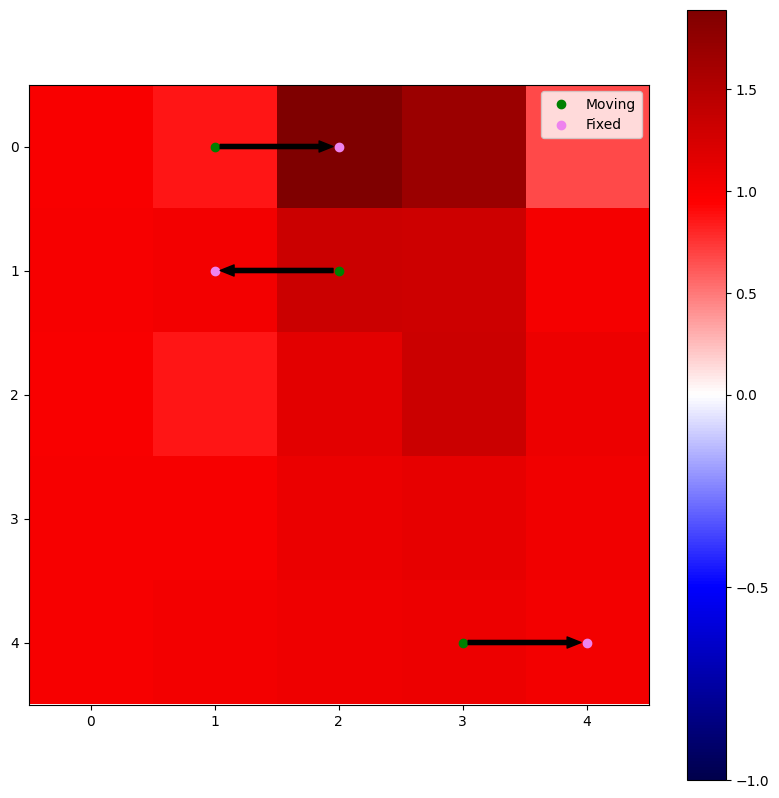

In [17]:
# Create some example correspondence points
"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
])
"""

# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 1, 2],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 1, 1],  # Middle
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])


"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
    [0, 3, 3],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
    [0, 1, 1]
])
"""

# Visualize the points
"""
plt.figure(figsize=(10, 10))
plt.scatter(msample[:, 2], msample[:, 1], c='g')
plt.scatter(fsample[:, 2], fsample[:, 1], c='r')
for i in range(len(msample)):
    plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='blue', alpha=0.75)
plt.gca().invert_yaxis()
plt.show()
"""

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

Check angles / orientations between vectors

In [18]:
import numpy as np

def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")

The vectors do not differ by a lot: 14.04 degrees


Try on a larger sample

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
(3, 3, 20, 40)
Shape of A: (2400, 2400)
Rank of A: 2400
SITK deformation shape: (3, 20, 40, 3)
Minimum Jacobian determinant: -13.527255162742511
Maximum Jacobian determinant: 14.65474248786702
Number of negative Jacobian determinants: 149
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 2251
Jaocbian det shape: (3, 20, 40)


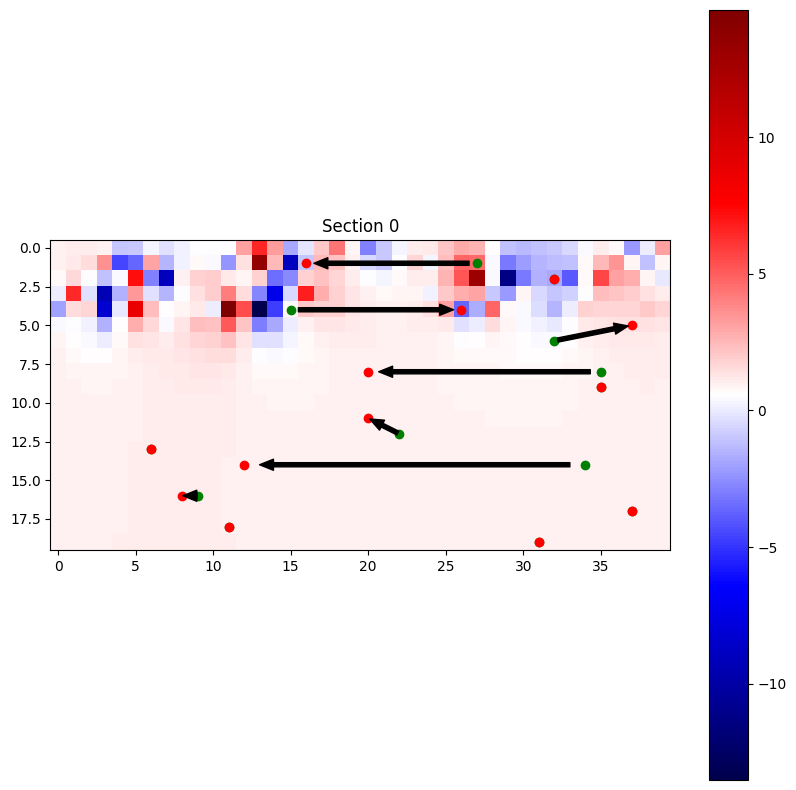

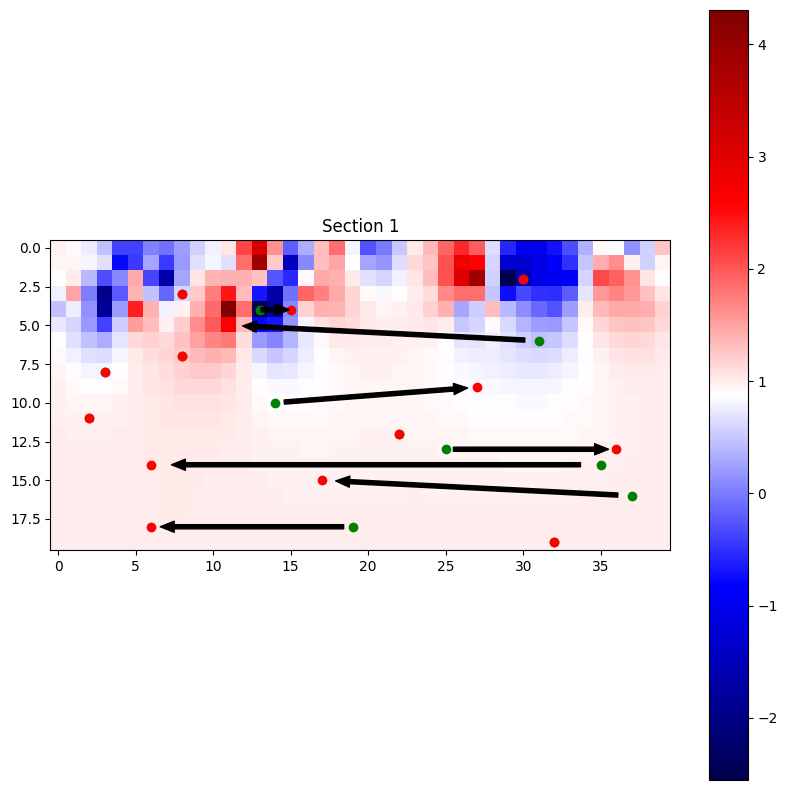

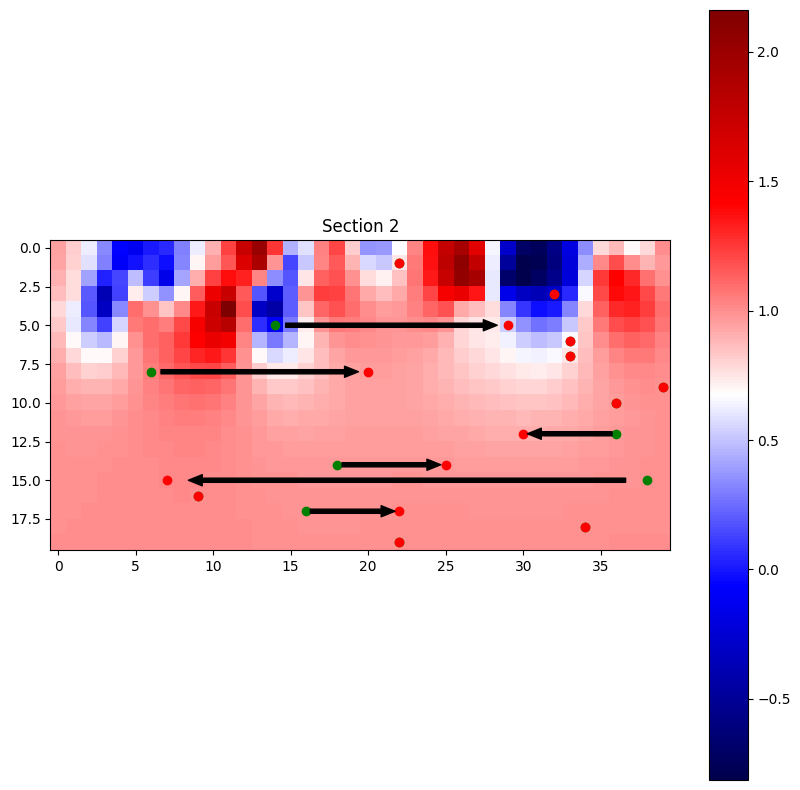

In [19]:
# Create sample set of points
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)

# Create a Laplacian matrix from the downsampled correspondence points
USE_ONE_IDX = False
# Select specific indices
if USE_ONE_IDX:
    curr_idx = 2
    curr_mpoints = mpoints[mpoints[:, 0] == curr_idx].copy()
    curr_fpoints = fpoints[fpoints[:, 0] == curr_idx].copy()
    curr_mpoints[:, 0] = 0
    curr_fpoints[:, 0] = 0
    print(curr_mpoints.shape)
    print(curr_fpoints.shape)
    fixed_sample = np.zeros((1, 20, 40))
else:
    # Use all indices
    curr_mpoints = mpoints.copy()
    curr_fpoints = fpoints.copy()
    fixed_sample = np.zeros((3, 20, 40))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, curr_mpoints, curr_fpoints)
print(deformation.shape)
print("Shape of A:", A.shape)
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))

# Visualize the Jacobian determinants
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))
print("Jaocbian det shape:", jacobian_det.shape)
for i in range(jacobian_det.shape[0]):
    plt.figure(figsize=(10, 10))
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())
    plt.imshow(jacobian_det[i], cmap='seismic')
    plt.title("Section " + str(i))
    plt.colorbar()
    
    curr_mpoints_slice = mpoints[mpoints[:, 0] == i][:, 1:]
    curr_fpoints_slice = fpoints[fpoints[:, 0] == i][:, 1:]

    plt.scatter(curr_mpoints_slice[:, 1], curr_mpoints_slice[:, 0], c='g')
    plt.scatter(curr_fpoints_slice[:, 1], curr_fpoints_slice[:, 0], c='r')
    
    for j in range(len(curr_mpoints_slice)):
        plt.annotate(
            '', 
            xy=(curr_fpoints_slice[j][1], curr_fpoints_slice[j][0]), 
            xytext=(curr_mpoints_slice[j][1], curr_mpoints_slice[j][0]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    #for j in range(len(curr_mpoints_slice)):
    #    plt.plot([curr_mpoints_slice[j][1], curr_fpoints_slice[j][1]], 
    #             [curr_mpoints_slice[j][0], curr_fpoints_slice[j][0]], color='blue', alpha=0.75)
    
    plt.show()


In [20]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood

curr_point = fpoints[0]
print("Current point:", curr_point)
get_neighborhood(fpoints[0], fpoints, 10)

Current point: [ 0.  1. 16.]


array([[ 0.,  1., 16.],
       [ 0.,  8., 20.],
       [ 1.,  3.,  8.],
       [ 1.,  4., 15.],
       [ 1.,  5., 11.],
       [ 2.,  1., 22.],
       [ 2.,  8., 20.]])